<a href="https://colab.research.google.com/github/arunraja-hub/Cache-in-C/blob/master/bidirectional_gru_nmt_with_attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

In [ ]:
!wget http://data.cstr.inf.ed.ac.uk/summa/data/english_punctuation/train.txt

--2020-11-05 06:36:01--  http://data.cstr.inf.ed.ac.uk/summa/data/english_punctuation/train.txt
Resolving data.cstr.inf.ed.ac.uk (data.cstr.inf.ed.ac.uk)... 129.215.202.26
Connecting to data.cstr.inf.ed.ac.uk (data.cstr.inf.ed.ac.uk)|129.215.202.26|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26792972 (26M) [text/plain]
Saving to: ‘train.txt.3’

train.txt.3         100%[===================>]  25.55M  6.12MB/s    in 4.9s    

2020-11-05 06:36:07 (5.23 MB/s) - ‘train.txt.3’ saved [26792972/26792972]



In [ ]:
!head -n 10 train.txt

20080401_002000_bbcthree_pulling_spk-0001_seg-0001992:0002105 YES <COMMA> IT IS <FULL_STOP>
20080401_002000_bbcthree_pulling_spk-0001_seg-0003779:0004482 I THINK MAYBE THIS IS THE RIGHT TIME FOR ME TO OPEN UP <COMMA> LET SOMEONE IN <FULL_STOP>
20080401_002000_bbcthree_pulling_spk-0001_seg-0006479:0006955 I'M A FLASHER <COMMA> LOUISE <FULL_STOP> I'M A RECOVERING FLASHER <FULL_STOP>
20080401_002000_bbcthree_pulling_spk-0001_seg-0050530:0051841 THIS IS GREAT <FULL_STOP> SIX MONTHS AGO I WOULD HAVE FELT COMPELLED TO SHOW HER MY PENIS <FULL_STOP> BUT NOW <COMMA> HERE I AM SITTING HERE LIKE A NORMAL PERSON <FULL_STOP> IT'S SO POSITIVE <FULL_STOP>
20080401_002000_bbcthree_pulling_spk-0001_seg-0052239:0052334 KISS ME <EXCLAMATION_MARK>
20080401_002000_bbcthree_pulling_spk-0001_seg-0054076:0054941 MY THERAPIST SAYS THAT IT'S ONLY BY BEING UPFRONT AND CONFRONTING THE PAST THAT WE LAY THE GROUNDWORK FOR A FUTURE <FULL_STOP> A FUTURE WITH YOU <FULL_STOP>
20080401_002000_bbcthree_pulling_spk-0001_s

In [ ]:
PUNCTUATION_MARKS = [
  '<FULL_STOP>', '<COMMA>', '<QUESTION_MARK>', '<EXCLAMATION_MARKS>', '<DOTS>'
]

def preprocess_sentence(sentence):
  output_words = []
  output_punctuation_marks = []

  words = sentence.split()[1:]
  for (word, punctuation_mark) in zip(words, words[1:] + [None]):
    if word in PUNCTUATION_MARKS:
      continue

    if punctuation_mark not in PUNCTUATION_MARKS:
      punctuation_mark = "<SPACE>"

    output_words.append(word)
    output_punctuation_marks.append(punctuation_mark)

  return [
      "<start> %s <end>" % " ".join(output_words),
      "<start> %s <end>" % " ".join(output_punctuation_marks)
  ]

def create_dataset(path, num_examples):
  lines = io.open(path, encoding='UTF-8').read().strip().split('\n')
  word_pairs = [preprocess_sentence(l) for l in lines if len(l.split()) <= 40][:num_examples]
  return list(zip(*word_pairs))

In [ ]:
words, punctuations = create_dataset('train.txt', 10000)
print(list(words))
print(type(punctuations))
print(words)

['<start> YES IT IS <end>', '<start> I THINK MAYBE THIS IS THE RIGHT TIME FOR ME TO OPEN UP LET SOMEONE IN <end>', "<start> I'M A FLASHER LOUISE I'M A RECOVERING FLASHER <end>", "<start> THIS IS GREAT SIX MONTHS AGO I WOULD HAVE FELT COMPELLED TO SHOW HER MY PENIS BUT NOW HERE I AM SITTING HERE LIKE A NORMAL PERSON IT'S SO POSITIVE <end>", '<start> KISS ME <EXCLAMATION_MARK> <end>', "<start> MY THERAPIST SAYS THAT IT'S ONLY BY BEING UPFRONT AND CONFRONTING THE PAST THAT WE LAY THE GROUNDWORK FOR A FUTURE A FUTURE WITH YOU <end>", "<start> I AM YEAH YEAH IT'S GREAT <end>", '<start> YES KAREN I HAVE GOT A PAST <end>', '<start> THANKS FOR THAT <end>', "<start> I'M A CONVICTED SEX OFFENDER <end>", "<start> YOU THINK THAT'S WHY I'M LEAVING <end>", '<start> I THOUGHT YOU COULD ACCEPT MY PAST <end>', "<start> WOULDN'T WANT TO EMBARRASS YOU IF SIR PAUL MCCARTNEY HAPPENS TO DROP BY MIKE <end>", '<start> SHALL I PICK THE MEAT OFF ANOTHER SCOTCH EGG FOR YOU <end>', '<start> SHIT <end>', "<start> 

In [ ]:
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
  lang_tokenizer.fit_on_texts(lang)
  tensor = lang_tokenizer.texts_to_sequences(lang)
  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

  return tensor, lang_tokenizer

In [ ]:
# def load_dataset(path, num_examples=None):
#   # creating cleaned input, output pairs
#   inp_lang, targ_lang = create_dataset(path, num_examples)

#   input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
#   target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

#   return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer


def load_dataset(path, num_examples):
  # creating cleaned input, output pairs
  # sentence = "utt I AM <COMMA> YEAH <FULL_STOP> YEAH <COMMA> IT'S GREAT <FULL_STOP>"
  w,p = create_dataset('train.txt', num_examples)
  inp_lang, targ_lang = list(w),list(p)
      # *[preprocess_sentence(sentence) for _ in range(num_examples)])

  input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
  target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

  return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

### Limit the size of the dataset to experiment faster (optional)

Training on the complete dataset of >100,000 sentences will take a long time. To train faster, we can limit the size of the dataset to 30,000 sentences (of course, translation quality degrades with less data):

In [ ]:
# Try experimenting with the size of that dataset
path_to_file = 'train.txt'
num_examples = 150000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)

# Calculate max_length of the target tensors
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]

In [ ]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Show length
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

120000 120000 30000 30000


In [ ]:
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.index_word[t]))

In [ ]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
79 ----> that's
85 ----> good
738 ----> frame
924 ----> sam
2 ----> <end>

Target Language; index to word mapping
3 ----> <start>
1 ----> <space>
2 ----> <full_stop>
1 ----> <space>
2 ----> <full_stop>
4 ----> <end>


In [ ]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 256
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)


val_dataset = tf.data.Dataset.from_tensor_slices((input_tensor_val, target_tensor_val)).shuffle(BUFFER_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)
print(vocab_inp_size)
print(vocab_tar_size)

43303
8


In [ ]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 40]), TensorShape([64, 40]))

In [ ]:
# # coding: utf-8
# from __future__ import division

# import tensorflow as tf
# from tensorflow.keras import layers
# import numpy as np 
# # import data

# def _get_shape(i, o, keepdims):
#     if (i == 1 or o == 1) and not keepdims:
#         return [max(i,o),]
#     else:
#         return [i, o]

# def _slice(tensor, size, i):
#     """Gets slice of columns of the tensor"""
#     return tensor[:, i*size:(i+1)*size]
    
# def weights_Glorot(i, o, name, rng, is_logistic_sigmoid=False, keepdims=False):
#     #http://jmlr.org/proceedings/papers/v9/glorot10a/glorot10a.pdf
#     d = np.sqrt(6. / (i + o))
#     if is_logistic_sigmoid:
#         d *= 4.
#     return tf.Variable(tf.random.uniform(_get_shape(i, o, keepdims), -d, d))

# def load(file_path, x, p=None):
#     import models
#     import pickle
#     import numpy as np

#     with open(file_path, 'rb') as f:
#         state = pickle.load(f)

#     Model = getattr(models, state["type"])

#     rng = np.random
#     rng.set_state(state["random_state"])

#     net = Model(
#         rng=rng,
#         x=x,
#         n_hidden=state["n_hidden"]
#         )

#     for net_param, state_param in zip(net.params, state["params"]):
#         net_param.assign(state_param)

#     return net, (state["learning_rate"], state["validation_ppl_history"], state["epoch"], rng)

# class GRUCell(layers.Layer):

#     def __init__(self, rng, n_in, n_out, minibatch_size):
#         super(GRUCell, self).__init__()
#         # Notation from: An Empirical Exploration of Recurrent Network Architectures

#         self.n_in = n_in
#         self.n_out = n_out

#         # Initial hidden state
#         self.h0 = tf.zeros([minibatch_size, n_out])

#         # Gate parameters:
#         self.W_x = weights_Glorot(n_in, n_out*2, 'W_x', rng)
#         self.W_h = weights_Glorot(n_out, n_out*2, 'W_h', rng)
#         self.b = tf.Variable(tf.zeros([1, n_out*2]))
#         # Input parameters
#         self.W_x_h = weights_Glorot(n_in, n_out, 'W_x_h', rng)
#         self.W_h_h = weights_Glorot(n_out, n_out, 'W_h_h', rng)
#         self.b_h = tf.Variable(tf.zeros([1, n_out]))

#         self.params = [self.W_x, self.W_h, self.b, self.W_x_h, self.W_h_h, self.b_h]
    
#     # inputs = x_t, h_tm1
#     def call(self, inputs):

#         rz = tf.nn.sigmoid(tf.matmul(inputs[0], self.W_x) + tf.matmul(inputs[1], self.W_h) + self.b)
#         r = _slice(rz, self.n_out, 0)
#         z = _slice(rz, self.n_out, 1)

#         h = tf.nn.tanh(tf.matmul(inputs[0], self.W_x_h) + tf.matmul(inputs[1] * r, self.W_h_h) + self.b_h)

#         h_t = z * inputs[1] + (1. - z) * h

#         return h_t

# class GRU(tf.keras.Model):

#     def __init__(self, rng, x, n_hidden):
#         super(GRU, self).__init__()

#         self.minibatch_size = tf.shape(x)[1]

#         self.n_hidden = n_hidden
#         self.x_vocabulary = input_tensor_train
#         # data.read_vocabulary(data.WORD_VOCAB_FILE)
#         self.y_vocabulary = target_tensor_train
#         # data.read_vocabulary(data.PUNCT_VOCAB_FILE)

#         self.x_vocabulary_size = len(self.x_vocabulary)
#         self.y_vocabulary_size = len(self.y_vocabulary)

#         # input model
#         self.We = weights_Glorot(self.x_vocabulary_size, n_hidden, 'We', rng) # Share embeddings between forward and backward model
#         self.GRU_f = GRUCell(rng=rng, n_in=n_hidden, n_out=n_hidden, minibatch_size=self.minibatch_size)
#         self.GRU_b = GRUCell(rng=rng, n_in=n_hidden, n_out=n_hidden, minibatch_size=self.minibatch_size)

#         # output model
#         # *2
#         self.GRU = GRUCell(rng=rng, n_in=n_hidden, n_out=n_hidden, minibatch_size=self.minibatch_size)
#         self.Wy = tf.Variable(tf.zeros([n_hidden, self.y_vocabulary_size]))
#         self.by = tf.Variable(tf.zeros([1, self.y_vocabulary_size]))

#         # attention model
#         n_attention = n_hidden * 2 # to match concatenated forward and reverse model states
#         self.Wa_h = weights_Glorot(n_hidden, n_attention, 'Wa_h', rng) # output model previous hidden state to attention model weights
#         self.Wa_c = weights_Glorot(n_attention, n_attention, 'Wa_c', rng) # contexts to attention model weights
#         self.ba = tf.Variable(tf.zeros([1, n_attention]))
#         self.Wa_y = weights_Glorot(n_attention, 1, 'Wa_y', rng) # gives weights to contexts

#         # Late fusion parameters
#         self.Wf_h = tf.Variable(tf.zeros([n_hidden, n_hidden]))
#         self.Wf_c = tf.Variable(tf.zeros([n_attention, n_hidden]))
#         self.Wf_f = tf.Variable(tf.zeros([n_hidden, n_hidden]))
#         self.bf = tf.Variable(tf.zeros([1, n_hidden]))

#         self.params = [self.We,
#                        self.Wy, self.by,
#                        self.Wa_h, self.Wa_c, self.ba, self.Wa_y,
#                        self.Wf_h, self.Wf_c, self.Wf_f, self.bf]

#         self.params += self.GRU.params + self.GRU_f.params + self.GRU_b.params
#         print([x.shape for x in self.params])
        
#     def call(self, inputs, training=None):

#         # bi-directional recurrence
#         def input_recurrence(initializer, elems):
#             x_f_t, x_b_t = elems
#             h_f_tm1, h_b_tm1 = initializer

#             h_f_t = self.GRU_f(inputs=(tf.nn.embedding_lookup(self.We, x_f_t), h_f_tm1))
#             h_b_t = self.GRU_b(inputs=(tf.nn.embedding_lookup(self.We, x_b_t), h_b_tm1))
#             return [h_f_t, h_b_t]

#         [h_f_t, h_b_t] = tf.scan(
#             fn=input_recurrence,
#             elems=[inputs, inputs[::-1]], # forward and backward sequences
#             initializer=[self.GRU_f.h0, self.GRU_b.h0]
#         )

#         # 0-axis is time steps, 1-axis is batch size and 2-axis is hidden layer size
#         context = tf.concat([h_f_t, h_b_t[::-1]], axis=2)
#         #projected_context = tf.matmul(context, self.Wa_c) + self.ba for each tensor slice
#         projected_context = tf.matmul(context, tf.tile(tf.expand_dims(self.Wa_c, 0), tf.stack([tf.shape(context)[0], 1, 1]))) + self.ba

#         def output_recurrence(initializer, elems):
#             x_t = elems
#             h_tm1, _, _ = initializer

#             # Attention model
#             h_a = tf.nn.tanh(projected_context + tf.matmul(h_tm1, self.Wa_h))

#             #alphas = tf.exp(tf.matmul(h_a, self.Wa_y))
#             #alphas = tf.reshape(alphas, [tf.shape(alphas)[0], tf.shape(alphas)[1]]) # drop 2-axis (sized 1) is replaced by:
#             #sess.run(tf.reshape(tf.matmul(tf.reshape(x, [-1, tf.shape(x)[-1]]), tf.expand_dims(z,-1)), tf.shape(x)[:2]))
#             alphas = tf.exp(tf.reshape(tf.matmul(tf.reshape(h_a, [-1, tf.shape(h_a)[-1]]), tf.expand_dims(self.Wa_y, -1)), tf.shape(h_a)[:2]))
#             alphas = alphas / tf.reduce_sum(alphas, axis=0, keepdims=True)
#             weighted_context = tf.reduce_sum(context * alphas[:,:,None], axis=0)
            
#             h_t = self.GRU(inputs=(x_t, h_tm1))

#             # Late fusion
#             lfc = tf.matmul(weighted_context, self.Wf_c) # late fused context
#             fw = tf.nn.sigmoid(tf.matmul(lfc, self.Wf_f) + tf.matmul(h_t, self.Wf_h) + self.bf) # fusion weights
#             hf_t = lfc * fw + h_t # weighted fused context + hidden state

#             z = tf.matmul(hf_t, self.Wy) + self.by
#             y_t = z#tf.nn.softmax(z)

#             return [h_t, hf_t, y_t]

#         [_, self.last_hidden_states, self.y] = tf.scan(
#             fn=output_recurrence,
#             elems=context[1:], # ignore the 1st word in context, because there's no punctuation before that
#             initializer=[self.GRU.h0, self.GRU.h0, tf.zeros([self.minibatch_size, self.y_vocabulary_size])]
#         )
        
#         return self.y

# def cost(y_pred, y_true):
#     return tf.reduce_sum(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=y_pred, labels=y_true))

# def save(model, file_path, learning_rate=None, validation_ppl_history=None, best_validation_ppl=None, epoch=None, random_state=None):
#     import pickle
#     state = {
#         "type":                     model.__class__.__name__,
#         "n_hidden":                 model.n_hidden,
#         "params":                   [p for p in model.params],
#         "learning_rate":            learning_rate,
#         "validation_ppl_history":   validation_ppl_history,
#         "epoch":                    epoch,
#         "random_state":             random_state
#     }
#     print([x.shape for x in state["params"]])

#     with open(file_path, 'wb') as f:
#         pickle.dump(state, f, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# from __future__ import division

# from time import time

# # import models, data
# import pickle
# import sys
# import os.path

# import tensorflow as tf
# import numpy as np

# MAX_EPOCHS = 50
# MINIBATCH_SIZE = 32
# CLIPPING_THRESHOLD = 2.0
# PATIENCE_EPOCHS = 1

# """
# Bi-directional RNN with attention
# For a sequence of N words, the model makes N punctuation decisions (no punctuation before the first word, but there's a decision after the last word or before </S>)
# """

# def get_minibatch(dataset, batch_size, shuffle, with_pauses=False):

#     # with open(file_name, 'rb') as f:
#     #     dataset = pickle.load(f)

#     # if shuffle:
#     #     np.random.shuffle(dataset)

#     X_batch = []
#     Y_batch = []

#     # if len(dataset) < batch_size:
#     #     lenwarning = (
#     #     f"WARNING: Not enough samples in {file_name}. "
#     #     f"Reduce mini-batch size to {len(dataset)} "
#     #     f"or use a dataset with at least {MINIBATCH_SIZE * data.MAX_SEQUENCE_LEN} words."
#     #     )
#     #     print(lenwarning)

#     # print(dataset[0][0])
#     # print(dataset[0][1])
#     for subsequence in dataset:

#         X_batch.append(subsequence[0])
#         print(np.shape(subsequence[0]))
#         Y_batch.append(subsequence[1])
#         print(np.shape(subsequence[1]))

#         if len(X_batch) == batch_size:

#             # Transpose, because the model assumes the first axis is time
#             X = np.array(X_batch, dtype=np.int32).T
#             Y = np.array(Y_batch, dtype=np.int32).T

#             yield X, Y

#             X_batch = []
#             Y_batch = []

# @tf.function
# def train_step(model, x, y):
#     with tf.GradientTape() as tape:
#         y_pred = model(x, training=True)
#         loss = models.cost(y_pred, y)
#     gradients = tape.gradient(loss, model.params)
#     gradients, _ = tf.clip_by_global_norm(gradients, clip_norm=CLIPPING_THRESHOLD)
#     optimizer.apply_gradients(zip(gradients, model.params))
#     return loss

# # if __name__ == "__main__":
    
# # starting_time = time()
# # if len(sys.argv) > 1:
# # model_name = sys.argv[1]
# # else:
# # sys.exit("'Model name' argument missing!")

# # if len(sys.argv) > 2:
# # num_hidden = int(sys.argv[2])
# # else:
# # sys.exit("'Hidden layer size' argument missing!")

# # if len(sys.argv) > 3:
# # learning_rate = float(sys.argv[3])
# # else:
# # sys.exit("'Learning rate' argument missing!")

# model_file_name = "Model_.pcl" 
# # % (model_name, num_hidden, learning_rate)

# num_hidden = 512
# learning_rate = 0.00001

# print(num_hidden, learning_rate, model_file_name)

# rng = np.random
# rng.seed(1)

# print("Building model ...")
# vocab_len = vocab_inp_size
# # len(data.read_vocabulary(data.WORD_VOCAB_FILE))
# x_len = vocab_len 
# # if vocab_len < data.MAX_WORD_VOCABULARY_SIZE else data.MAX_WORD_VOCABULARY_SIZE + data.MIN_WORD_COUNT_IN_VOCAB
# x = np.ones((x_len, MINIBATCH_SIZE)).astype(int)
# # Initialize the weights of the model without any real data, comparable to placeholders in earlier Tensorflow version
# net = GRU(rng, x, num_hidden)
# optimizer = tf.keras.optimizers.Adagrad(learning_rate=learning_rate, initial_accumulator_value=1e-6)

# starting_epoch = 0
# best_ppl = np.inf
# validation_ppl_history = []

# print(f"Total number of trainable parameters: {sum(np.prod([dim for dim in param.get_shape()]) for param in net.params)}")

# print("Training...")
# for epoch in range(starting_epoch, MAX_EPOCHS):
#   t0 = time()
#   total_neg_log_likelihood = 0
#   total_num_output_samples = 0
#   iteration = 0 
#   for X, Y in get_minibatch(dataset, MINIBATCH_SIZE, shuffle=True):
#       loss = train_step(net, X, Y)
#       total_neg_log_likelihood += loss
#       total_num_output_samples += np.prod(Y.shape)
#       iteration += 1
#       if iteration % 100 == 0:
#           sys.stdout.write("PPL: %.4f; Speed: %.2f sps\n" % (np.exp(total_neg_log_likelihood / total_num_output_samples), total_num_output_samples / max(time() - t0, 1e-100)))
#           sys.stdout.flush()
#   print(f"Total number of training labels: {total_num_output_samples}")

#   total_neg_log_likelihood = 0
#   total_num_output_samples = 0
#   for X, Y in get_minibatch(val_dataset, MINIBATCH_SIZE, shuffle=False):
#       total_neg_log_likelihood += models.cost(net(X, training=True), Y)
#       print(f"Total neg log likelihood in dev iteration {iteration}, epoch {epoch}: {total_neg_log_likelihood}")
#       total_num_output_samples += np.prod(Y.shape)
#       print(f"Total num output samples in dev iteration {iteration}, epoch {epoch}: {total_num_output_samples}")
#   print(f"Total number of validation labels: {total_num_output_samples}")

#   ppl = np.exp(total_neg_log_likelihood / total_num_output_samples)
#   validation_ppl_history.append(ppl)

#   print(f"Validation perplexity is {np.round(ppl, 4)}")

#   if ppl <= best_ppl:
#       best_ppl = ppl
#       models.save(net, model_file_name, learning_rate=learning_rate, validation_ppl_history=validation_ppl_history, best_validation_ppl=best_ppl, epoch=epoch, random_state=rng.get_state())
#   elif best_ppl not in validation_ppl_history[-PATIENCE_EPOCHS:]:
#       print("Finished!")
#       print(f"Best validation perplexity was {best_ppl}")
#       print(f"Total time: {time() - starting_time}")
#       break

In [ ]:
# # num_gru_layers = 3

# def gru_cell(enc_units):
#   return tf.keras.layers.GRUCell(enc_units, recurrent_initializer='glorot_uniform')

# class Encoder(tf.keras.Model):
#   def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
#     super(Encoder, self).__init__()
#     self.batch_sz = batch_sz
#     self.enc_units = enc_units
#     self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
#     forward_layer = tf.keras.layers.RNN(gru_cell(self.enc_units))
#     backward_layer = tf.keras.layers.RNN(gru_cell(self.enc_units), go_backwards = True)
#     self.bid_gru = tf.keras.layers.Bidirectional(forward_layer, backward_layer=backward_layer)
                      

#   def call(self, x, hidden):
#     x = self.embedding(x)
#     print(self.bid_gru(x, initial_state=[hidden, hidden]).shape)
#     outputs = self.bid_gru(x, initial_state=[hidden, hidden])
#     return outputs[0],outputs[-1]



#   def initialize_hidden_state(self):
#       init_state = tf.zeros((self.batch_sz, self.enc_units)) 
#       print(init_state[0].shape)
#       return init_state

class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(self.enc_units, return_sequences=True, return_state=True))

  def call(self, x, hidden):
    x = self.embedding(x)
    outputs = self.gru(x)
    # , initial_state=hidden)
    return outputs[0], outputs[-1]

  def initialize_hidden_state(self):
    return [tf.zeros((self.batch_sz, self.enc_units)) for _ in range(2)]

In [ ]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
print('hidden',len(sample_hidden))
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

hidden 2
Encoder output shape: (batch size, sequence length, units) (64, 40, 512)
Encoder Hidden state shape: (batch size, units) (64, 256)


In [ ]:

class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # query hidden state shape == (batch_size, hidden size)
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    # we are doing this to broadcast addition along the time axis to calculate the score
    query_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(query_with_time_axis) + self.W2(values)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [ ]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 512)
Attention weights shape: (batch_size, sequence_length, 1) (64, 40, 1)


In [ ]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

In [ ]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 8)


## Define the optimizer and the loss function

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

## Checkpoints (Object-based saving)

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [ ]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [ ]:
EPOCHS = 50

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1, batch, batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  if epoch == EPOCHS:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1, total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 0.7038
Epoch 1 Batch 100 Loss 0.1971
Epoch 1 Batch 200 Loss 0.2001
Epoch 1 Batch 300 Loss 0.2103
Epoch 1 Batch 400 Loss 0.1979
Epoch 1 Batch 500 Loss 0.2055
Epoch 1 Batch 600 Loss 0.1975
Epoch 1 Batch 700 Loss 0.1627
Epoch 1 Batch 800 Loss 0.1786
Epoch 1 Batch 900 Loss 0.1727
Epoch 1 Batch 1000 Loss 0.1853
Epoch 1 Batch 1100 Loss 0.1232
Epoch 1 Batch 1200 Loss 0.1115
Epoch 1 Batch 1300 Loss 0.1285
Epoch 1 Batch 1400 Loss 0.1716
Epoch 1 Batch 1500 Loss 0.1420
Epoch 1 Batch 1600 Loss 0.1346
Epoch 1 Batch 1700 Loss 0.1472
Epoch 1 Batch 1800 Loss 0.1245
Epoch 1 Loss 0.1615
Time taken for 1 epoch 350.1117641925812 sec

Epoch 2 Batch 0 Loss 0.1054
Epoch 2 Batch 100 Loss 0.1204
Epoch 2 Batch 200 Loss 0.1363
Epoch 2 Batch 300 Loss 0.1036
Epoch 2 Batch 400 Loss 0.1101
Epoch 2 Batch 500 Loss 0.1098
Epoch 2 Batch 600 Loss 0.1248
Epoch 2 Batch 700 Loss 0.1415
Epoch 2 Batch 800 Loss 0.1316
Epoch 2 Batch 900 Loss 0.1010
Epoch 2 Batch 1000 Loss 0.1114
Epoch 2 Batch 1100 Loss 0.10

In [ ]:
# # coding: utf-8
# from __future__ import division

# # import models, data, main

# import sys
# import codecs

# import tensorflow as tf
# import numpy as np

# MAX_SUBSEQUENCE_LEN = 200

# def to_array(arr, dtype=np.int32):
#     # minibatch of 1 sequence as column
#     return np.array([arr], dtype=dtype).T

# def convert_punctuation_to_readable(punct_token):
#     if punct_token == data.SPACE:
#         return " "
#     else:
#         return punct_token[0]

# def restore(output_file, text, word_vocabulary, reverse_punctuation_vocabulary, model):
#     i = 0
#     with codecs.open(output_file, 'w', 'utf-8') as f_out:
#         while True:

#             subsequence = text[i:i+MAX_SUBSEQUENCE_LEN]

#             if len(subsequence) == 0:
#                 break

#             converted_subsequence = [word_vocabulary.get(w, word_vocabulary[data.UNK]) for w in subsequence]

#             y = predict(to_array(converted_subsequence), model)

#             f_out.write(subsequence[0])

#             last_eos_idx = 0
#             punctuations = []
#             for y_t in y:

#                 p_i = np.argmax(tf.reshape(y_t, [-1]))
#                 punctuation = reverse_punctuation_vocabulary[p_i]

#                 punctuations.append(punctuation)

#                 if punctuation in data.EOS_TOKENS:
#                     last_eos_idx = len(punctuations) # we intentionally want the index of next element

#             if subsequence[-1] == data.END:
#                 step = len(subsequence) - 1
#             elif last_eos_idx != 0:
#                 step = last_eos_idx
#             else:
#                 step = len(subsequence) - 1

#             for j in range(step):
#                 f_out.write(" " + punctuations[j] + " " if punctuations[j] != data.SPACE else " ")
#                 if j < step - 1:
#                     f_out.write(subsequence[1+j])

#             if subsequence[-1] == data.END:
#                 break

#             i += step

# def predict(x, model):
#     return tf.nn.softmax(net(x))

# # if __name__ == "__main__":

# #     if len(sys.argv) > 1:
# #         model_file = sys.argv[1]
# #     else:
# #         sys.exit("Model file path argument missing")

# #     if len(sys.argv) > 2:
# #         input_file = sys.argv[2]
# #     else:
# #         sys.exit("Input file path argument missing")

# #     if len(sys.argv) > 3:
# #         output_file = sys.argv[3]
# #     else:
# #         sys.exit("Output file path argument missing")

# vocab_len = vocab_inp_size
# # len(data.read_vocabulary(data.WORD_VOCAB_FILE))
# x_len = vocab_len
# #  if vocab_len < data.MAX_WORD_VOCABULARY_SIZE else data.MAX_WORD_VOCABULARY_SIZE + data.MIN_WORD_COUNT_IN_VOCAB
# x = np.ones((x_len, MINIBATCH_SIZE)).astype(int)

# print("Loading model parameters...")
# net, _ = load(model_file, x)

# print("Building model...")

# word_vocabulary = net.x_vocabulary
# punctuation_vocabulary = net.y_vocabulary

# reverse_word_vocabulary = {v:k for k,v in word_vocabulary.items()}
# reverse_punctuation_vocabulary = {v:k for k,v in punctuation_vocabulary.items()}

# with codecs.open(input_file, 'r', 'utf-8') as f:
#     input_text = f.read()

# if len(input_text) == 0:
#     sys.exit("Input file empty.")

# text = [w for w in input_text.split() if w not in punctuation_vocabulary and w not in data.PUNCTUATION_MAPPING and not w.startswith(data.PAUSE_PREFIX)] + [data.END]
# pauses = [float(s.replace(data.PAUSE_PREFIX,"").replace(">","")) for s in input_text.split() if s.startswith(data.PAUSE_PREFIX)]

# restore(output_file, text, word_vocabulary, reverse_punctuation_vocabulary, net)

## Translate

* The evaluate function is similar to the training loop, except we don't use *teacher forcing* here. The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.
* Stop predicting when the model predicts the *end token*.
* And store the *attention weights for every time step*.

Note: The encoder output is calculated only once for one input.

In [ ]:
def evaluate(sentence):
  sentence = preprocess_sentence(sentence)[0]

  inputs = inp_lang.texts_to_sequences([sentence])
  inputs = tf.convert_to_tensor(inputs)
  result = ''

  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

  for t in range(max_length_targ):
    predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_out)

    predicted_id = tf.argmax(predictions[0]).numpy()
    result += targ_lang.index_word[predicted_id] + ' '

    if targ_lang.index_word[predicted_id] == '<end>':
      return result, sentence

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence

In [ ]:
def translate(sentence):
  result, input_sentence = evaluate(sentence)

  print('Input: %s' % (input_sentence))
  print('Predicted translation: {}'.format(result))

## Restore the latest checkpoint and test

In [ ]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
translate(u'utt I AM <COMMA> YEAH <FULL_STOP> YEAH <COMMA> IT\'S GREAT <FULL_STOP>')

Input: <start> I AM YEAH YEAH IT'S GREAT <end>
Predicted translation: <space> <space> <comma> <space> <space> <space> <space> <space> <space> <space> <space> <space> <space> <space> <space> <space> <space> <space> <space> <space> <space> <space> <space> <space> <space> <space> <space> <space> <space> <space> <space> <space> <space> <space> <space> <space> <space> <space> <space> <space> 


In [ ]:
translate(u'utt YES <COMMA> 2 <COMMA> I HAVE GOT A PAST <FULL_STOP>')

Input: <start> YES 2 I HAVE GOT A PAST <end>
Predicted translation: <comma> <space> <space> <space> <space> <space> <space> <space> <space> <space> <space> <space> <space> <space> <space> <space> <space> <space> <space> <space> <space> <space> <space> <space> <space> <space> <space> <space> <space> <space> <space> <space> <space> <space> <space> <space> <space> <space> <space> <space> 


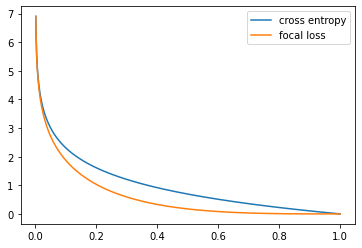

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(0.001, 1, 1000)
y1 = -np.log(x)
y2 = (1-x) ** 2.0 * -np.log(x)

plt.plot(x, y1, label='cross entropy')
plt.plot(x, y2, label='focal loss')
plt.legend()
plt.show()